In [59]:
#
# File: project2.py
#

## top-level submission file

'''
Note: Do not import any other modules here.
        To import from another file xyz.py here, type
        import project2_py.xyz
        However, do not import any modules except numpy in those files.
        It's ok to import modules only in files that are
        not imported here (e.g. for your plotting code).
'''
import numpy as np

def local_descent(x, alpha, d):
    x_next = x + alpha*d
    return x_next

def gradient_descent(x, alpha, g):
    g = g(x)
    d = -g/np.linalg.norm(g)
    x_next = local_descent(x, alpha, d)
    return x_next

def backtrack_line_search_for_grad(f, g, x, d, alpha, p = .5, B = 1e-4):
    y = f(x)
    while(f(x + alpha*d) > y + B*alpha*(np.dot(g,d))):
        alpha *= p
    return alpha

def gradient_descent_with_line_search(f, x, alpha, g, c_prime, pro):
    gr = g(x)
    d = -gr/np.linalg.norm(gr)
    alpha = backtrack_line_search_for_grad(f, gr, x, d, alpha)
    x_next = local_descent(x, alpha, d)
    return x_next

def momentum(g, x, v, alpha, B): 
    g = g(x)
    norm_g = g/np.linalg.norm(g)
    v_next = B*v - alpha*norm_g
    x_next = x + v_next
    return x_next, v_next

def nesterov_momentum(g, x, v, alpha, B, c_prime, pro):
    gr = g(x + B*v)
    norm_gr = gr/np.linalg.norm(gr)
    v_next = B*v - alpha*norm_gr
    x_next = x + v_next
    return x_next, v_next

def p_inv_barrier(x,c):
    return -sum(1/c(x))

def p_quadratic(x, c):
    c_eval = c(x)
    zer_vec = np.zeros(len(c_eval))
    max_vec = np.maximum(c_eval, zer_vec)
    p = (np.linalg.norm(max_vec)**2)
    return p

def p_count(c_eval, h_eval):
    p = np.sum((c_eval > 0)) 
    return p

def basis(i,n):
    return [1.0 if k == i else 0.0 for k in range(n)]


def Hooke_Jeeves_penalty(f, c, p, pro, x, alpha, hooke_epsilon, gamma = .5):
    y = f(x) + pro*p(x, c)
    n = len(x)
    while alpha > hooke_epsilon:
        improved = False
        x_best, y_best = x, y
        for i in range(n):
            for sgn in [-1, 1]:
                x_prime = x + sgn*alpha*np.array(basis(i,n))
                y_prime = f(x_prime) + pro*p(x_prime, c)
                if(y_prime < y_best):
                    x_best, y_best, improved = x_prime, y_prime, True
        
        x, y = x_best, y_best
        if (not improved):
            alpha *= gamma
    
    return x

def simulated_annealing_penalty(f, c, p, pro, x, T, t, kmax):
    y = f(x) + pro*p(x, c)
    x_best, y_best = x, y
    for k in range(kmax):
        x_prime = x + np.random.standard_normal(T)
        y_prime = f(x_prime) + pro*p(x_prime, c)
        delt_y = y_prime - y
        if (delt_y <= 0 or np.random.rand() < np.exp(-delt_y/t)):
            x, y = x_prime, y_prime
        if (y_prime < y_best):
            x_best, y_best = x_prime, y_prime
        t *= (1/(k+1))
    
    return x_best

def optimize(f, g, c, x0, n, count, prob):
    """
    Args:
        f (function): Function to be optimized
        g (function): Gradient function for `f`
        c (function): Function evaluating constraints
        x0 (np.array): Initial position to start from
        n (int): Number of evaluations allowed. Remember `f` and `c` cost 1 and `g` costs 2
        count (function): takes no arguments are reutrns current count
        prob (str): Name of the problem. So you can use a different strategy 
                 for each problem. `prob` can be `simple1`,`simple2`,`simple3`,
                 `secret1` or `secret2`
    Returns:
        x_best (np.array): best selection of variables found
    """
    x_last = x0
    v_last = np.zeros(len(x0))
    pro = 1
    gamma = 2
    delta = np.inf
    eps = .1
    hooke_eps = .1

    x_history = [x0]
    f_history = []
    iters = 0

    while(count() < n):
        iters = iters + 1
        if prob == "simple1":
           alpha = .5
           x_best = Hooke_Jeeves_penalty(f, c, p_quadratic, pro, x_last, alpha, hooke_eps)
           x_history.append(x_best)
           pro *= gamma
           if p_quadratic(x_best, c) == 0:
               return x_history

        elif prob == "simple2":
            alpha = .5
            x_best = Hooke_Jeeves_penalty(f, c, p_quadratic, pro, x_last, alpha, hooke_eps)
            pro *= gamma
            if p_quadratic(x_best, c) == 0:
                return x_best

        elif prob == "simple3":
            alpha = .5
            gamma = 8
            x_best = Hooke_Jeeves_penalty(f, c, p_quadratic, pro, x_last, alpha, hooke_eps)
            pro *= gamma
            if p_quadratic(x_best, c) == 0:
                return x_best
                
        elif prob == "secret1":
            alpha = .5
            gamma = 8
            x_best = Hooke_Jeeves_penalty(f, c, p_quadratic, pro, x_last, alpha, hooke_eps)
            pro *= gamma
            if p_quadratic(x_best, c) == 0:
                return x_best

        elif prob == "secret2": 
            T = len(x_last)
            t = 1
            kmax = 1
            x_best = simulated_annealing_penalty(f, c, p_quadratic, pro, x_last, T, t, kmax)
            pro *= gamma
            if p_quadratic(x_best, c) == 0:
                return x_best
                
        else:
            return float("nan")

    #     x_history.append(x_best)

    # x_history.append(x_best)
    # for x in x_history:
    #     f_history.append(f(x))

    # return x_history

In [60]:
#
# File: helpers.py
#

# this file defines the optimization problems and test

from tqdm import tqdm
import numpy as np

class OptimizationProblem:

    @property
    def xdim(self):
        # dimension of x
        return self._xdim

    @property
    def prob(self):
        # problem name
        return self._prob
    
    @property
    def n(self):
        # number of allowed evaluations
        return self._n
    
    def _reset(self):
        self._ctr = 0

    def count(self):
        return self._ctr

    def nolimit(self):
        # sets n to inf, useful for plotting/debugging
        self._n = np.inf
        
    def x0(self):
        '''
        Returns:
            x0 (np.array): (xdim,) randomly initialized x
        '''
        return np.random.randn(self.xdim)

    def f(self, x):
        '''Evaluate f
        Args:
            x (np.array): input
        Returns:
            f (float): evaluation
        '''
        assert x.ndim == 1

        self._ctr += 1

        return self._wrapped_f(x)
    
    def _wrapped_f(self, x):
        raise NotImplementedError

    def g(self, x):
        '''Evaluate jacobian of f
        Args:
            x (np.array): input
        Returns:
            jac (np.array): jacobian of f wrt x
        '''
        assert x.ndim == 1

        self._ctr += 2

        return self._wrapped_g(x)

class ConstrainedOptimizationProblem(OptimizationProblem):

    @property
    def cdim(self):
        # number of constraints
        return self._cdim

    @property
    def nc(self):
        # number of allowed constraint evals
        return self._nc

    def _reset(self):
        self._ctr = 0

    def count(self):
        return self._ctr

    def nolimit(self):
        # sets n to inf, useful for plotting/debugging
        self._n = np.inf

    def c(self, x):
        '''Evaluate constraints
        Args:
            x (np.array): input
        Returns:
            c (np.array): (cdim,) evaluation of constraints
        '''
        assert x.ndim == 1
        
        self._ctr += 1

        return self._wrapped_c(x)

    def _wrapped_c(self, x):
        raise NotImplementedError


class Simple1(ConstrainedOptimizationProblem):
    
    def __init__(self):
        self._xdim = 2
        self._cdim = 2
        self._prob = 'simple1'
        self._n = 2000
        self._reset()

    def x0(self):
        return np.random.rand(self._xdim) * 2.0

    def _wrapped_f(self, x):
        return -x[0] * x[1]  + 2.0 / (3.0 * np.sqrt(3.0))

    def _wrapped_g(self, x):
        return np.array([
            -x[1],
            -x[0],
                ])

    def _wrapped_c(self,x):
        return np.array([
            x[0] + x[1]**2 - 1,
            -x[0] - x[1]
            ])



class Simple2(ConstrainedOptimizationProblem):

    def __init__(self):
        self._xdim = 2
        self._cdim = 2
        self._prob = 'simple2'
        self._n = 2000
        self._reset()

    def x0(self):
        return np.random.rand(self._xdim) * 2.0 - 1.0

    def _wrapped_f(self, x):
        return 100 * (x[1] - x[0]**2)**2 + (1-x[0])**2

    def _wrapped_g(self, x):
        return np.array([
            2*(-1 + x[0] + 200*x[0]**3 - 200*x[0]*x[1]),
            200*(-x[0]**2 + x[1])
                ])

    def _wrapped_c(self,x):
        return np.array([
            (x[0]-1)**3 - x[1] + 1,
            x[0] + x[1] - 2,
            ])


class Simple3(ConstrainedOptimizationProblem):

    def __init__(self):
        self._xdim = 3
        self._cdim = 1
        self._prob = 'simple3'
        self._n = 2000
        self._reset()

    def x0(self):
        b = 2.0 * np.array([1.0, -1.0, 0.0])
        a = -2.0 * np.array([1.0, -1.0, 0.0])
        return np.random.rand(3) * (b-a) + a

    def _wrapped_f(self, x):
        return x[0] - 2*x[1] + x[2] + np.sqrt(6.0)

    def _wrapped_g(self, x):
        return np.array([1., -2., 1.])

    def _wrapped_c(self, x):
        return np.array([x[0]**2 + x[1]**2 + x[2]**2 - 1.])



def test_optimize(optimize):
    '''
    Tests optimize to ensure it passes
    Args:
        optimize (function): function optimizing a given problem
    '''

    for test in [Simple1, Simple2, Simple3]:

        p = test()
        
        print('Testing on %s...' % p.prob)

        solution_feasible = []
        any_count_exceeded = False
        for seed in tqdm(range(500)):
            p = test()
            p.nolimit() # for plotting
            np.random.seed(seed)
            x0 = p.x0()
            xb = optimize(p.f, p.g, p.c, x0, p.n, p.count, p.prob)
            if p.count() > p.n:
                any_count_exceeded = True
                break
            p._reset()
            solution_feasible.append(np.all(p.c(xb) <= 0.0))

        if any_count_exceeded:
            print('Failed %s. Count exceeded.'%p.prob)
            continue

        # to pass, optimize must return a feasible point >=95% of the time.

        numfeas = np.sum(solution_feasible)
        if numfeas >= 0.95*500:
            print('Pass: optimize returns a feasible solution on %d/%d random seeds.' % (numfeas,500))
        else:
            print('Fail: optimize returns a feasible solution on %d/%d random seeds.' % (numfeas,500))

    return
    



In [74]:
import matplotlib.pyplot as plt

def simple1_plot(optimize, x0):
    test = Simple1
    p = test()
    numpoints = 100
    x1 = np.linspace(-3.0, 3.0, numpoints)
    x2 = np.linspace(-3.0, 3.0, numpoints)
    X1, X2 = np.meshgrid(x1, x2)
    Z = -X1*X2 + (2/(3*np.sqrt(3)))

    plt.contour(X1,X2,Z,np.logspace(-0.5,3.5,8,base=10), cmap = 'gray')

    plt.title('Optimization Path for Simple1 with Hooke Jeeves and Quadratic Penalty')
    plt.xlabel('x1')
    plt.ylabel('x2')

    # x_list = []
    # y_list = []
    # for x in x1:
    #     for y in x2:
    #         pt = np.array([x, y])
    #         if(x + y**2 - 1 <= 0 and -x - y <= 0):
    #             plt.plot(x,y, 'o', markerfacecolor = "None", markeredgecolor = 'b')
    #             x_list.append(x)
    #             y_list.append(y)

    x,y = np.meshgrid(x1,x2)
    plt.imshow( ((x + y**2 - 1 <= 0) & (-x - y <= 0)).astype(int) , 
                extent=(x.min(),x.max(),y.min(),y.max()),origin="lower", cmap="Blues", alpha = 0.3);   
    
    plt.axis([-3, 3, -3, 3])

    x_history = optimize(p.f, p.g, p.c, x0, p.n, p.count, p.prob)
    x_hist = np.array(x_history)
    x1_opt = x_hist[:,0]
    x2_opt = x_hist[:,1]
    plt.plot(x1_opt, x2_opt, '-', color='red') 
    p._reset()
    return

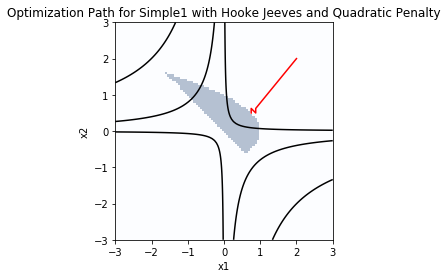

In [80]:
x0 = np.array([2, 2])
simple1_plot(optimize, x0)

